In [1]:
# ライブラリインポート
import torch, torchaudio
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import math

from torch.utils.data import random_split, DataLoader
from torchemotion.datasets.EmodbDataset import EmodbDataset
from torchemotion.datasets.IemocapDataset import IemocapDataset
from transformers import Wav2Vec2Processor, WavLMModel, WavLMForSequenceClassification, WavLMConfig #, WavLMForCTC
from IPython.display import Audio, display
from tqdm.notebook import tqdm

[Emodb dataset](https://www.kaggle.com/datasets/piyushagni5/berlin-database-of-emotional-speech-emodb)

kaggleに上がっていたのでそこから入手

In [3]:
!ls

data		     'SER_ review.pptx'  torchemotion  WavLM.ipynb
EmoDB.zip	     SER_with_cnn.ipynb  utils	       wavlm_summary.ipynb
make_download.ipynb  speechbrain	 wandb
SER_model.ipynb      speechbrain.ipynb	 wavlm


In [2]:
# IEMOCAP
Iemocap = IemocapDataset(root='./data/IEMOCAP_full_release',
                        emotions=['ang', 'hap', 'exc', 'sad', 'fru', 'fea', 'sur', 'neu', 'xxx'])
Iemocap[0]

{'path': './data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F000.wav',
 'waveform': tensor([[-0.0034, -0.0037, -0.0033,  ..., -0.0053, -0.0050, -0.0036]]),
 'sample_rate': 16000,
 'emotion': 7.0,
 'activation': 4.0,
 'valence': 2.0,
 'dominance': 2.5}

In [ ]:
for i in range(len(Iemocap)):
    print(Iemocap[i]['emotion'])

In [3]:
emodb = EmodbDataset(root='data/EmoDB/')
emodb.__getitem__(0)

{'waveform': tensor([[ 0.0000, -0.0001,  0.0000,  ..., -0.0038, -0.0040, -0.0042]]),
 'sample_rate': 16000,
 'emotion': 4}

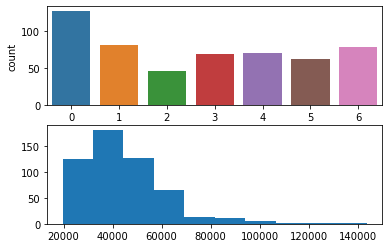

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

num_labels=7
emotions = list()
lengths = list()
for i in range(len(emodb)):
    emotions.append(int(emodb.__getitem__(i)['emotion']-1))
    lengths.append(emodb.__getitem__(i)['waveform'].size(-1))

df_emo = pd.DataFrame(emotions, columns=['emotion'])

fig, ax = plt.subplots(2,1)
ax1, ax2 = ax
sns.countplot(x='emotion', data=df_emo, ax=ax1)
ax2.hist(lengths)

plt.show()

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_data(dataset):
    emotions = list()
    lengths = list()
    for i in range(len(subset)):
        data = subset[i]
        emotions.append(int(data['emotion']))
        lengths.append(data['waveform'].size(-1))

    df_emo = pd.DataFrame(emotions, columns=['emotion'])

    fig, ax = plt.subplots(2,1)
    ax1, ax2 = ax
    sns.countplot(x='emotion', data=df_emo, ax=ax1)
    ax2.hist(lengths)

    plt.show()
    
    return emotions, lengths

/gs/hs1/tga-i/otake.s.ad/SER/torchemotion/datasets/IemocapDataset.py:58: FutureWarning: Could not cast to float32, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  self.df = pd.DataFrame(data, columns=['start', 'end', 'file', 'emotion', 'activation', 'valence', 'dominance', 'session', 'script_impro', 'gender', 'utterance'], dtype=np.float32)


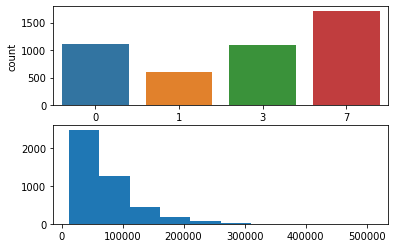

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

labels = ['ang', 'hap', 'sad', 'neu']
Iemocap = IemocapDataset(root='./data/IEMOCAP_full_release', emotions=labels)
num_labels = 4
emotions = list()
lengths = list()
for i in range(len(Iemocap)):
    data = Iemocap[i]
    '''if data['emotion'] == 7.0:
        data['emotion'] = 4.0'''
    emotions.append(int(data['emotion']))
    lengths.append(data['waveform'].size(-1))

df_emo = pd.DataFrame(emotions, columns=['emotion'])

fig, ax = plt.subplots(2,1)
ax1, ax2 = ax
sns.countplot(x='emotion', data=df_emo, ax=ax1)
ax2.hist(lengths)

plt.show()

In [16]:
df_emo.value_counts()

emotion
7          1701
0          1096
3          1060
1           592
dtype: int64

In [14]:
def filter_length(dataset, labels, lthresh=250000):
    emo_count = {}
    for l in labels:
        emo_count[l] = 0
    for i in range(len(dataset)):
        data = dataset[i]
        if data['waveform'].size(-1) < lthresh:
            emo_count[int(data['emotion'])] += 1
    return min(list(emo_count.values())), emo_count

In [15]:
labels = ['ang', 'hap', 'sad', 'neu']
Iemocap = IemocapDataset(root='./data/IEMOCAP_full_release', emotions=labels)
filter_length(Iemocap, labels = [0, 1, 3, 7], lthresh=100000)

/gs/hs1/tga-i/otake.s.ad/SER/torchemotion/datasets/IemocapDataset.py:58: FutureWarning: Could not cast to float32, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  self.df = pd.DataFrame(data, columns=['start', 'end', 'file', 'emotion', 'activation', 'valence', 'dominance', 'session', 'script_impro', 'gender', 'utterance'], dtype=np.float32)


(468, {0: 871, 1: 468, 3: 758, 7: 1444})

In [16]:
MAX

0

In [21]:
labels = ['ang', 'hap', 'sad', 'neu']
Iemocap = IemocapDataset(root='./data/IEMOCAP_full_release', emotions=labels)

# lthresh未満の音声の均衡クラスラベルデータセットを作成
num_labels = 4
lthresh = 100000

emo_dict = {}
emo_dict_flag = {}
labels = [0, 1, 3, 7]
MAX, _ = filter_length(Iemocap, labels=[0,1,3,7], lthresh=lthresh)
for label in labels:
    emo_dict[label] = 0
    emo_dict_flag[label] = True
subset = []
for i in range(len(Iemocap)):
    data = Iemocap[i]
    emotion = int(data['emotion'])
    if data['waveform'].size(-1) < lthresh:
        if emo_dict_flag[emotion]:
            #pdb.set_trace()
            if emotion == 3:
                data['emotion'] = 2.0
            elif emotion == 7:
                data['emotion'] = 3.0
            subset.append(data)
            emo_dict[emotion] += 1
            if emo_dict[emotion] == MAX:
                print(f'{emotion}_emotion is reached at MAX')
                emo_dict_flag[emotion] = False
        if sum(list(emo_dict_flag.values())) == 0:
            break
subset[0]

/gs/hs1/tga-i/otake.s.ad/SER/torchemotion/datasets/IemocapDataset.py:58: FutureWarning: Could not cast to float32, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  self.df = pd.DataFrame(data, columns=['start', 'end', 'file', 'emotion', 'activation', 'valence', 'dominance', 'session', 'script_impro', 'gender', 'utterance'], dtype=np.float32)


7_emotion is reached at MAX
3_emotion is reached at MAX
0_emotion is reached at MAX
1_emotion is reached at MAX


{'path': './data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F000.wav',
 'waveform': tensor([[-0.0034, -0.0037, -0.0033,  ..., -0.0053, -0.0050, -0.0036]]),
 'sample_rate': 16000,
 'emotion': 3.0,
 'activation': 4.0,
 'valence': 2.0,
 'dominance': 2.5}

In [20]:
MAX

468

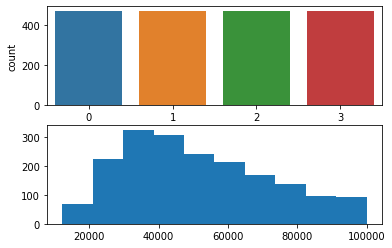

In [22]:
emotions, lengths = plot_data(subset)

In [5]:
import pandas as pd
pd.DataFrame(emotions).value_counts()

0    592
1    592
2    592
3    592
dtype: int64

In [2]:
labels = ['ang', 'hap', 'sad', 'neu']
Iemocap = IemocapDataset(root='./data/IEMOCAP_full_release', emotions=labels)

/gs/hs1/tga-i/otake.s.ad/SER/torchemotion/datasets/IemocapDataset.py:58: FutureWarning: Could not cast to float32, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  self.df = pd.DataFrame(data, columns=['start', 'end', 'file', 'emotion', 'activation', 'valence', 'dominance', 'session', 'script_impro', 'gender', 'utterance'], dtype=np.float32)


In [26]:
lengths = torch.tensor(lengths)
subset = [Iemocap[i] for i, v in enumerate((lengths<250000).tolist()) if v]
subset[0]

{'path': './data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F000.wav',
 'waveform': tensor([[-0.0034, -0.0037, -0.0033,  ..., -0.0053, -0.0050, -0.0036]]),
 'sample_rate': 16000,
 'emotion': 7.0,
 'activation': 4.0,
 'valence': 2.0,
 'dominance': 2.5}

In [21]:
len(subset)

5477

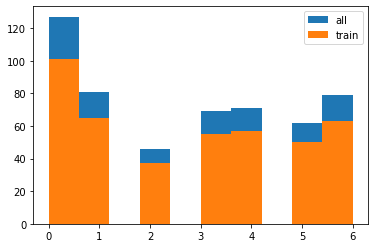

In [56]:
# dataset stratified by emotion
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

emotions = [int(emodb.__getitem__(i)['emotion'])-1 for i in range(len(emodb))]
train_indices, val_indices = train_test_split(list(range(len(emotions))), test_size=0.2, stratify=emotions, random_state=42)
train_dataset = torch.utils.data.Subset(emodb, train_indices)
val_dataset = torch.utils.data.Subset(emodb, val_indices)

emotions_train = [int(train_dataset.__getitem__(i)['emotion'])-1 for i in range(len(train_dataset))]
plt.hist(emotions, label='all')
plt.hist(emotions_train, label='train')
plt.legend()
plt.show()

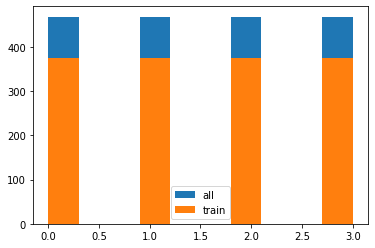

In [24]:
# dataset stratified by emotion
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

dataset = subset

emotions = [int(dataset[i]['emotion']) for i in range(len(dataset))]

train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2, stratify=emotions, random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

emotions_train = [int(train_dataset.__getitem__(i)['emotion']) for i in range(len(train_dataset))]
plt.hist(emotions, label='all')
plt.hist(emotions_train, label='train')
plt.legend()
plt.show()

(array([1041., 1735., 1033.,  637.,  405.,  259.,  146.,  105.,   58.,
          58.]),
 array([  9359.,  33351.,  57343.,  81335., 105327., 129319., 153311.,
        177303., 201295., 225287., 249279.]),
 <BarContainer object of 10 artists>)

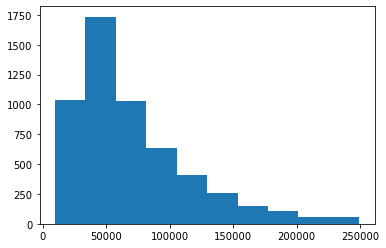

In [28]:
lengths = [subset[i]['waveform'].size(-1) for i in range(len(subset))]
plt.hist(lengths)

In [17]:
processor = Wav2Vec2Processor.from_pretrained("patrickvonplaten/wavlm-libri-clean-100h-base-plus") # 前処理
#wavlm = WavLMModel.from_pretrained("patrickvonplaten/wavlm-libri-clean-100h-base-plus") # wavlm

In [4]:
wavlmcl = WavLMForSequenceClassification.from_pretrained("patrickvonplaten/wavlm-libri-clean-100h-base-plus")

Some weights of the model checkpoint at patrickvonplaten/wavlm-libri-clean-100h-base-plus were not used when initializing WavLMForSequenceClassification: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing WavLMForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing WavLMForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of WavLMForSequenceClassification were not initialized from the model checkpoint at patrickvonplaten/wavlm-libri-clean-100h-base-plus and are newly initialized: ['classifier.weight', 'projector.bias', 'projector.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to b

In [ ]:
# collate_fn
# processor = Wav2Vec2Processor.from_pretrained("patrickvonplaten/wavlm-libri-clean-100h-base-plus") # 前処理

def pad_sequence(batch):
    # ゼロ埋めによりバッチに含まれる全てのテンソルを同じ長さにする

    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    #print(batch.shape)
    return batch.permute(0, 2, 1)

def collate_fn(batch):


    waveforms, targets = [], []
    input_data = {}

    # リストにまとめ、ラベルをインデックスでエンコードする
    for data in batch:
        waveforms += [data['waveform']]
        targets += [torch.tensor(int(data['emotion'])-1)]

    # テンソルのリストをまとめてバッチ化されたテンソルにする
    waveforms = pad_sequence(waveforms)
    waveforms = [torch.flatten(w) for w in waveforms]
    inputs = [processor(waveform, sampling_rate=16000, return_tensors='pt', padding=True) for waveform in waveforms]
    input_data['input_values'] = torch.stack([inputs[i]['input_values'].flatten() for i in range(len(batch))])
    input_data['attention_mask'] = torch.stack([inputs[i]['attention_mask'].flatten() for i in range(len(batch))])

    targets = torch.stack(targets)

    return input_data, targets

In [4]:
# collate_fn
# processor = Wav2Vec2Processor.from_pretrained("patrickvonplaten/wavlm-libri-clean-100h-base-plus") 
# emodb
def collate_fn(batch):
    waveforms, targets = [], []
    input_data = {}

    # リストにまとめ、ラベルをインデックスでエンコードする
    for data in batch:
        waveforms += [data['waveform'].numpy().flatten()]
        targets += [torch.tensor(int(data['emotion'])-1)]

    # テンソルのリストをまとめてバッチ化されたテンソルにする
    '''waveforms = pad_sequence(waveforms)
    waveforms = torch.stack([torch.flatten(w) for w in waveforms])
'''
    targets = torch.stack(targets)

    return waveforms, targets

In [ ]:
# collate_fn
# processor = Wav2Vec2Processor.from_pretrained("patrickvonplaten/wavlm-libri-clean-100h-base-plus") 
# IEMOCAP
def collate_fn(batch):
    waveforms, targets = [], []
    input_data = {}

    # リストにまとめ、ラベルをインデックスでエンコードする
    for data in batch:
        waveforms += [data['waveform'].numpy().flatten()]
        emotion = data['emotion']
        targets += [torch.tensor(int(data['emotion']))]

    targets = torch.stack(targets)

    return waveforms, targets

In [7]:
# データローダー
from torch.utils.data import DataLoader

batch_size=8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [58]:
data,target = next(iter(train_loader))

In [59]:
data

[array([ 3.6621094e-04,  1.8310547e-04, -9.1552734e-05, ...,
        -1.1596680e-03, -8.2397461e-04, -3.9672852e-04], dtype=float32),
 array([-0.01104736, -0.01046753, -0.00863647, ..., -0.0043335 ,
        -0.00476074, -0.00500488], dtype=float32),
 array([-0.0090332 , -0.01098633, -0.01187134, ..., -0.00201416,
        -0.00204468, -0.00198364], dtype=float32),
 array([-0.0010376 , -0.00106812, -0.00189209, ..., -0.0045166 ,
        -0.00457764, -0.00466919], dtype=float32),
 array([-0.00305176, -0.00271606, -0.00256348, ...,  0.00299072,
         0.00299072,  0.0027771 ], dtype=float32),
 array([-0.00073242, -0.0010376 , -0.00131226, ..., -0.00030518,
        -0.00042725, -0.00061035], dtype=float32),
 array([ 0.00247192,  0.00219727,  0.00183105, ...,  0.00210571,
        -0.00653076, -0.01220703], dtype=float32),
 array([ 0.00802612,  0.00726318,  0.00668335, ..., -0.00076294,
        -0.00033569, -0.00012207], dtype=float32)]

In [61]:
target

tensor([0., 1., 0., 3., 3., 3., 0., 1.])

In [27]:
wavlm_config = WavLMConfig('patrickvonplaten/wavlm-libri-clean-100h-base-plus')
wavlm_config.update({'num_labels':7, 'use_weighted_layer_sum':True})

In [28]:
wavlm_config.num_labels

7

In [29]:
processor = Wav2Vec2Processor.from_pretrained("patrickvonplaten/wavlm-libri-clean-100h-base-plus") # 前処理
model = WavLMForSequenceClassification.from_pretrained("patrickvonplaten/wavlm-libri-clean-100h-base-plus", config=wavlm_config)

Some weights of the model checkpoint at patrickvonplaten/wavlm-libri-clean-100h-base-plus were not used when initializing WavLMForSequenceClassification: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing WavLMForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing WavLMForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of WavLMForSequenceClassification were not initialized from the model checkpoint at patrickvonplaten/wavlm-libri-clean-100h-base-plus and are newly initialized: ['layer_weights', 'classifier.weight', 'projector.bias', 'projector.weight', 'classifier.bias']
You should probably TRAIN this model on a down

In [30]:
model.config.use_weighted_layer_sum

True

In [ ]:
inputs = processor(data, sampling_rate=16000, returns_tensor='pt', padding=True)
output = model(**input, labels=target)
output

In [32]:
output.logits.shape

torch.Size([8, 7])

In [10]:
# モデルの定義
class SERwithWavLM(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.processor =  Wav2Vec2Processor.from_pretrained(pretrained_model)
        self.wavlm = WavLMModel.from_pretrained(pretrained_model)
        self.fc = nn.Linear(768, 7)
    
    def forward(self, input):
        input = self.processor(input, sampling_rate=16000,  return_tensors='pt', padding=True)
        for k in input.keys():
            input[k] = input[k].to(device)
        wavlm_output = self.wavlm(**input).last_hidden_state
        output = self.fc(wavlm_output.mean(dim=1))
        return output, wavlm_output


'''device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SERwithWavLM("patrickvonplaten/wavlm-libri-clean-100h-base-plus")
#model = nn.DataParallel(model, list(range(4)))
model.to(device)'''

'device = torch.device(\'cuda\' if torch.cuda.is_available() else \'cpu\')\n\nmodel = SERwithWavLM("patrickvonplaten/wavlm-libri-clean-100h-base-plus")\n#model = nn.DataParallel(model, list(range(4)))\nmodel.to(device)'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SERwithWavLM("patrickvonplaten/wavlm-libri-clean-100h-base-plus")
model = nn.DataParallel(model, list(range(4)))
model.to(device)

In [18]:
for name, param in model.named_parameters():
    if 'fc' in name:
        print(name)
        param.requires_grad = True
    else:
        param.requires_grad = False

NameError: name 'model' is not defined

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

Number of parameters: 5383


In [ ]:
# model動作確認
data, target = next(iter(train_loader))

model.eval()
with torch.no_grad():
    output, hidden_state = model(data)
output.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


torch.Size([8, 7])

In [ ]:
print(target)
print(output.argmax(-1))

tensor([0, 6, 3, 2, 6, 4, 6, 1])
tensor([4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')


In [ ]:
print(hidden_state)

In [ ]:
list(model.fc.parameters())

[Parameter containing:
 tensor([[-0.0037,  0.0032,  0.0257,  ..., -0.0358,  0.0293,  0.0250],
         [ 0.0314,  0.0140,  0.0354,  ...,  0.0177, -0.0351,  0.0253],
         [-0.0082, -0.0273, -0.0351,  ..., -0.0185,  0.0148, -0.0161],
         ...,
         [-0.0315, -0.0312, -0.0334,  ...,  0.0277,  0.0352,  0.0122],
         [-0.0125,  0.0157, -0.0210,  ...,  0.0099,  0.0216,  0.0143],
         [ 0.0026, -0.0029, -0.0121,  ...,  0.0315,  0.0253,  0.0318]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([ 0.0194, -0.0339, -0.0003, -0.0106, -0.0273,  0.0057,  0.0162],
        device='cuda:0', requires_grad=True)]

以降は
[speech_command tutorial](https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html)の流用


In [19]:
def number_of_correct(pred, target):
    # 正解数を数える
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # バッチの各要素について、最も確率の高いラベルインデックスを得る
    return tensor.argmax(dim=-1)


In [33]:
# 最適化 
lr = 0.001
optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5) 

In [7]:
import wandb
wandb.login()

wandb: Currently logged in as: shinos (use `wandb login --relogin` to force relogin)


True

wandb example
```python
# Launch 5 experiments, trying different dropout rates
for _ in range(5):
    # 🐝 initialise a wandb run
    wandb.init(
        project="pytorch-intro",
        config={
            "epochs": 10,
            "batch_size": 128,
            "lr": 1e-3,
            "dropout": random.uniform(0.01, 0.80),
            })
    
    # Copy your config 
    config = wandb.config

    # Get the data
    train_dl = get_dataloader(is_train=True, batch_size=config.batch_size)
    valid_dl = get_dataloader(is_train=False, batch_size=2*config.batch_size)
    n_steps_per_epoch = math.ceil(len(train_dl.dataset) / config.batch_size)
    
    # A simple MLP model
    model = get_model(config.dropout)

    # Make the loss and optimizer
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

   # Training
    example_ct = 0
    step_ct = 0
    for epoch in tqdm(range(config.epochs)):
        model.train()
        for step, (images, labels) in enumerate(tqdm(train_dl, leave=False)):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            train_loss = loss_func(outputs, labels)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
            example_ct += len(images)
            metrics = {"train/train_loss": train_loss, 
                       "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch, 
                       "train/example_ct": example_ct}
            
            if step + 1 < n_steps_per_epoch:
                # 🐝 Log train metrics to wandb 
                wandb.log(metrics)
                
            step_ct += 1

        val_loss, accuracy = validate_model(model, valid_dl, loss_func, log_images=(epoch==(config.epochs-1)))

        # 🐝 Log train and validation metrics to wandb
        val_metrics = {"val/val_loss": val_loss, 
                       "val/val_accuracy": accuracy}
        wandb.log({**metrics, **val_metrics})
        
        print(f"Train Loss: {train_loss:.3f}, Valid Loss: {val_loss:3f}, Accuracy: {accuracy:.2f}")

    # If you had a test set, this is how you could log it as a Summary metric
    wandb.summary['test_accuracy'] = 0.8

    # 🐝 Close your wandb run 
    wandb.finish()
```

```python
def number_of_correct(pred, target):
    # 正解数を数える
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # バッチの各要素について、最も確率の高いラベルインデックスを得る
    return tensor.argmax(dim=-1)


# train
def train(model, epoch, log_interval):
    model.train()
    correct = 0

    for step, (data, target) in enumerate(train_loader):
        #print(data)
        target = target.to(device)

        # モデルへ入力する
        output,_ = model(data)

        # クロスエントロピー誤差
        loss = F.cross_entropy(output, target, ignore_index=0)
        
        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        metrics = {"train/loss": loss.item()/len(data)}
        #if step + 1 < n_steps_per_epoch:
        wandb.log(metrics)
        #print(list(model.parameters())[0][0])
        # 訓練の統計値をプリントする
        if step % log_interval == 0:
            print(f"Train Epoch: {epoch} [{step * len(target)}/{len(train_loader.dataset)} ({100. * step / len(train_loader):.0f}%)]\tLoss: {loss.item()/len(data):.6f}")

        # プログレスバー更新
        pbar.update(pbar_update)
        # 損失を記録する
        losses.append(loss.item()/len(data))
    print(f"Accuracy: {correct}/{len(train_loader.dataset)} ({100. * correct / len(train_loader.dataset):.0f}%)")
    metrics = {'train/epoch_loss': sum(losses)/len(losses)}
    return metrics
```

```python
def test(model, epoch):
    model.eval()
    correct = 0
    example_ct = 0
    val_loss = 0
    for data, target in test_loader:
        example_ct += len(data)
        target = target.to(device)

        # モデルへ入力する
        output,_ = model(data)

        pred = get_likely_index(output)
        val_loss += F.cross_entropy(output, target, ignore_index=0)

        print(pred)
        correct += number_of_correct(pred, target)

        
        # プログレスバー更新
        pbar.update(pbar_update)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    val_metrics = {"val/val_loss": val_loss/example_ct, 
              "val/val_accuracy": accuracy}

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n")
    
    return val_metrics
```

In [17]:
torch.cuda.device_count()

4

```python
from tqdm.notebook import tqdm
import wandb

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

wandb.init(
    project="wavlm_SER_IEMOCAP",
    config={
        "pretrained_model": 'patrickvonplaten/wavlm-libri-clean-100h-base-plus',
        "epochs": 20,
        "batch_size": 8,
        "learning_rate": 0.0005, 
        "lr_scheduler_step": 20,
        "lr_scheduler_gamma": 0.5
        })
config = wandb.config

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False, collate_fn=collate_fn)

model = SERwithWavLM(config["pretrained_model"])
model = nn.DataParallel(model, list(range(4)))
model.to(device)

param_to_update = []
param_to_update_name = []
for name, param in model.named_parameters():
    if 'fc' in name:
        print(name)
        param.requires_grad = True
        param_to_update.append(param)
        param_to_update_name.append(name)
    else:
        param.requires_grad = False
        
wandb.config.update({"updated_param_name": param_to_update_name})
optimizer = torch.optim.Adam(param_to_update, lr=config['learning_rate'], weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config["lr_scheduler_step"], gamma=config["lr_scheduler_gamma"]) 

log_interval = 10
n_epoch = config["epochs"]

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []


with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        metrics = train(model, epoch, log_interval)
        val_metrics = test(model, epoch)
        scheduler.step()
        wandb.log({**metrics, **val_metrics})

# 訓練時の損失がイテレーション数に応じてどう変化するかをプロットする
# plt.plot(losses);
# plt.title("training loss");
```

In [22]:
dataloaders_dict = {'train': train_loader, 'val': test_loader}

In [30]:
for v in dataloaders_dict.values():
    print(len(v))

54
14


In [31]:
sum([len(v) for v in dataloaders_dict.values()])

68

In [54]:
target

tensor([2, 4, 6, 4, 2, 5, 1, 4])

In [63]:
len(train_loader.dataset)

1894

In [ ]:
da

In [ ]:
1 / sum([len(v) for v in dataloaders_dict.values()])

In [25]:
def train_model(model, dataloaders_dict, optimizer, scheduler, num_epochs, log_interval=10):

    '''# GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)
    print('-----start-------')
    # ネットワークをGPUへ
    model.to(device)'''
    
    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True
    
    log_intervals = 10
    pbar_update = 1 / sum([len(v) for v in dataloaders_dict.values()])
    
    processor = Wav2Vec2Processor.from_pretrained("patrickvonplaten/wavlm-libri-clean-100h-base-plus")
    with tqdm(total=num_epochs) as pbar:
        # epochのループ
        for epoch in range(num_epochs):
            # epochごとの訓練と検証のループ
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # モデルを訓練モードに
                else:
                    model.eval()   # モデルを検証モードに

                epoch_loss = 0.0  # epochの損失和
                epoch_corrects = 0  # epochの正解数

                # データローダーからミニバッチを取り出すループ
                for step, (data, target) in enumerate(dataloaders_dict[phase]):
                    # GPUが使えるならGPUにデータを送る
                    inputs = processor(data, sampling_rate=16000,  return_tensors='pt', padding=True)
                    for k in inputs.keys():
                        inputs[k] = inputs[k].to(device)
                    target = target.to(device)
                    inputs = (inputs, target)
                    
                    # optimizerを初期化
                    optimizer.zero_grad()

                    # 順伝搬（forward）計算
                    with torch.set_grad_enabled(phase == 'train'):

                        # modelに入力
                        # outputs, _ = model(inputs, target)
                        # loss = F.nll_loss(F.log_softmax(outputs, dim=-1), target)  # 損失を計算 reduction='mean'
                        logits, loss = model(inputs)
                        preds = torch.argmax(logits, dim=-1)  # ラベルを予測

                        # 訓練時はバックプロパゲーション
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            if scheduler is not None:
                                scheduler.step()
                            loss_log = loss.item()
                            del loss
                            if step % log_interval == 0:
                                print(f"Train Epoch: {epoch} [{step * len(data)}/{len(dataloaders_dict[phase].dataset)} ({100. * step / len(dataloaders_dict[phase]):.0f}%)]\tLoss: {loss_log:.6f}")
                            wandb.log({'train/loss': loss_log})
                            
                        else:
                            print(preds.to('cpu').detach().numpy())
                        # 結果の計算
                        epoch_loss += loss_log * len(data)
                        # 正解数の合計を更新
                        epoch_corrects += preds.squeeze().eq(target).sum().item()
                
                '''if phase=='train':
                    before = scheduler.get_lr()[0]
                    scheduler.step()
                    after = scheduler.get_lr()[0]
                    print(f'\nsceduler\n {before} -> {after}')'''
                    
                # epochごとのlossと正解率
                epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
                epoch_acc = epoch_corrects / len(dataloaders_dict[phase].dataset)
               
                metrics = {f'{phase}/epoch_loss': epoch_loss, f'{phase}/acc': epoch_acc}
                wandb.log(metrics)
                
                pbar.update(pbar_update)
                print('Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f}'.format(epoch+1, num_epochs,
                                                                               phase, epoch_loss, epoch_acc))

    return model


In [28]:
from tqdm.notebook import tqdm
import wandb
wandb.login()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

wandb.init(
    project="wavlm_SER",
    config={
        "pretrained_model": 'patrickvonplaten/wavlm-libri-clean-100h-base-plus',
        'dataset': 'IEMOCAP_balanced_subset_lthresh=100000',
        "epochs": 10,
        "batch_size": 8,
        "learning_rate": 0.0001, 
        "lr_scheduler_step": 300,
        "lr_scheduler_step_unit": 'batch_iter',
        "lr_scheduler_gamma": 0.9,
        "all_parameters": True
        })
config = wandb.config

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False, collate_fn=collate_fn)
dataloaders_dict = {'train': train_loader, 'val': test_loader}

# モデルの定義
class SERwithWavLM(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.wavlm_config = WavLMConfig(pretrained_model)
        self.wavlm_config.update({'num_labels':4, 'use_weighted_layer_sum':True})
        self.wavlm = WavLMForSequenceClassification.from_pretrained(pretrained_model, config=self.wavlm_config)
    
    def forward(self, inputs):
        outputs = self.wavlm(**inputs[0], labels=inputs[1]) 
        logits = outputs.logits
        loss = outputs.loss
        
        return logits, loss
    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        # Liner層の初期化
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)
            
model = SERwithWavLM(config["pretrained_model"])
model.wavlm.classifier.apply(weights_init)
model.to(device)

'''param_to_update = []
param_to_update_name = {}
for name, param in model.named_parameters():
    if 'classifier' in name:
        print(name)
        param.requires_grad = True
        param_to_update.append(param)
        param_to_update_name[f'{name}'] = 0.0001
    else:
        param.requires_grad = False'''

'''wandb.config.update({"updated_param": param_to_update_name})'''

optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=0.0001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config["lr_scheduler_step"], gamma=config["lr_scheduler_gamma"]) 

num_epochs = config["epochs"]

model = train_model(model, dataloaders_dict, optimizer, None, num_epochs, log_interval=10)

model_path = 'checkpoint/wavlm_IEMOCAP_5.pth'
torch.save(model.state_dict(), model_path)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Some weights of the model checkpoint at patrickvonplaten/wavlm-libri-clean-100h-base-plus were not used when initializing WavLMForSequenceClassification: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing WavLMForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing WavLMForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of WavLMForSequenceClassification were not initialized from the model checkpoint at patrickvonplaten/wavlm-libri-clean-100h-base-plus and are newly initialized: ['projector.weight', 'classifier.bias', 'classifier.weight', 'projector.bias', 'layer_weights']
You should probably TRAIN this model on a down

  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 0 [0/1497 (0%)]	Loss: 1.420434
Train Epoch: 0 [80/1497 (5%)]	Loss: 1.219347
Train Epoch: 0 [160/1497 (11%)]	Loss: 1.409039
Train Epoch: 0 [240/1497 (16%)]	Loss: 1.245827
Train Epoch: 0 [320/1497 (21%)]	Loss: 1.375381
Train Epoch: 0 [400/1497 (27%)]	Loss: 1.241039
Train Epoch: 0 [480/1497 (32%)]	Loss: 1.287493
Train Epoch: 0 [560/1497 (37%)]	Loss: 1.272001
Train Epoch: 0 [640/1497 (43%)]	Loss: 1.093808
Train Epoch: 0 [720/1497 (48%)]	Loss: 0.921091
Train Epoch: 0 [800/1497 (53%)]	Loss: 1.511650
Train Epoch: 0 [880/1497 (59%)]	Loss: 1.102845
Train Epoch: 0 [960/1497 (64%)]	Loss: 0.996432
Train Epoch: 0 [1040/1497 (69%)]	Loss: 1.128203
Train Epoch: 0 [1120/1497 (74%)]	Loss: 0.921378
Train Epoch: 0 [1200/1497 (80%)]	Loss: 1.158976
Train Epoch: 0 [1280/1497 (85%)]	Loss: 1.138573
Train Epoch: 0 [1360/1497 (90%)]	Loss: 1.215854
Train Epoch: 0 [1440/1497 (96%)]	Loss: 0.743695
Epoch 1/10 | train |  Loss: 1.1594 Acc: 0.4950
[2 0 2 2 1 2 1 0]
[0 2 1 3 0 2 2 2]
[2 2 2 1 1 1 0 0]
[3 2 

wandb: Network error (ReadTimeout), entering retry loop.


Train Epoch: 1 [640/1497 (43%)]	Loss: 1.304337
Train Epoch: 1 [720/1497 (48%)]	Loss: 0.987195
Train Epoch: 1 [800/1497 (53%)]	Loss: 0.618266
Train Epoch: 1 [880/1497 (59%)]	Loss: 1.323364
Train Epoch: 1 [960/1497 (64%)]	Loss: 0.728942
Train Epoch: 1 [1040/1497 (69%)]	Loss: 1.092866
Train Epoch: 1 [1120/1497 (74%)]	Loss: 1.460201
Train Epoch: 1 [1200/1497 (80%)]	Loss: 0.712858
Train Epoch: 1 [1280/1497 (85%)]	Loss: 0.879399
Train Epoch: 1 [1360/1497 (90%)]	Loss: 0.717871
Train Epoch: 1 [1440/1497 (96%)]	Loss: 0.995831
Epoch 2/10 | train |  Loss: 0.9958 Acc: 0.5912
[2 0 2 3 1 2 0 0]
[3 2 0 2 0 2 2 2]
[2 2 2 3 1 1 0 0]
[3 2 2 1 0 2 0 2]
[2 0 3 2 2 1 2 0]
[2 0 0 2 2 0 2 2]
[2 2 2 2 1 2 0 2]
[0 2 2 3 1 2 0 1]
[2 2 3 3 1 1 1 2]
[2 2 1 0 0 2 3 0]
[2 1 2 2 3 2 2 2]
[2 1 1 1 2 0 2 2]
[0 0 3 0 1 1 2 2]
[2 1 2 1 3 1 0 2]
[3 0 1 1 2 0 0 2]
[2 2 2 0 2 3 2 2]
[2 0 3 2 2 0 2 0]
[1 2 2 2 3 2 0 0]
[3 3 0 0 0 0 3 0]
[0 2 1 2 2 2 2 2]
[2 1 0 0 2 0 2 2]
[2 0 2 2 3 2 0 3]
[2 2 0 3 0 0 0 2]
[3 3 0 2 2 3 2 1